In [1]:
cd ..

c:\Users\Gebruiker\Documents\Uni\Master\MLiP\M5Forecasting\git\uncertainty


In [2]:
cd ..

c:\Users\Gebruiker\Documents\Uni\Master\MLiP\M5Forecasting\git


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Optimise MLP - level 1

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
level = 1

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Read data

In [6]:
if level <= 9:
    fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle'.format(level)
else:
    fn = data_dir + 'prep/level_{}_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle'.format(level)

# check if already preprocessed
if os.path.exists(fn):
    data = pd.read_pickle(fn)
else:
    # choose number of years to include
    if level <= 9:
        n_years = 6  # all
    else:
        n_years = 2
    
    # preform preprocessing
    data = preprocess(level=level, n_years=n_years, save_prepared_dataset=True, data_dir=data_dir)
    
# set categorical features
data, available_cat_features = pandas_cat_data(data)

# select features
sell_price_features = ('sell_price' in data.columns)
features = get_features(level=level, sell_price_features=sell_price_features)
print(features)

['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_t30', 'year', 'month', 'week', 'day', 'dayofweek', 'is_year_end', 'is_year_start', 'is_quarter_end', 'is_quarter_start', 'is_month_end', 'is_month_start', 'is_weekend']


## Setup training

In [7]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [8]:
def get_generators(batch_size=64):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

## Dense(64)

In [9]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 174)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11200       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [10]:
logger = Logger(val_batch_creator)

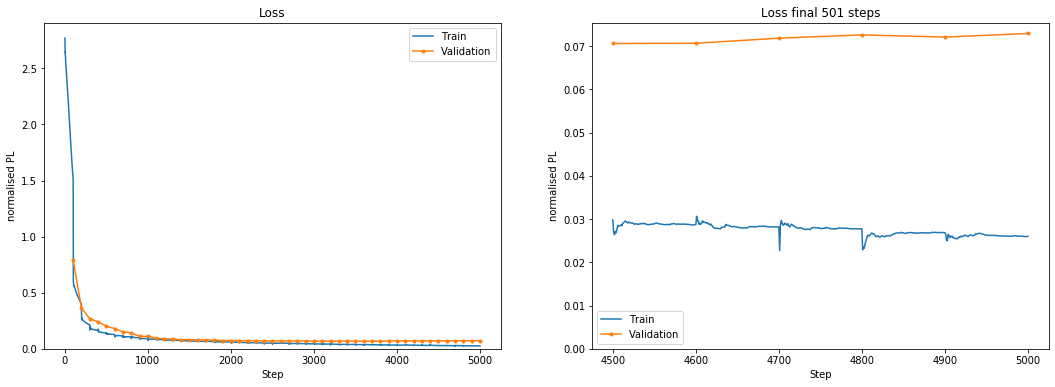

100/100 [==============================] - 12s 119ms/step - loss: 0.0260 - q0_loss: 5.7170e-04 - q1_loss: 0.0012 - q2_loss: 0.0037 - q3_loss: 0.0043 - q4_loss: 0.0053 - q5_loss: 0.0047 - q6_loss: 0.0040 - q7_loss: 0.0016 - q8_loss: 5.2801e-04 - val_loss: 0.0729 - val_q0_loss: 6.9138e-04 - val_q1_loss: 0.0018 - val_q2_loss: 0.0114 - val_q3_loss: 0.0116 - val_q4_loss: 0.0138 - val_q5_loss: 0.0138 - val_q6_loss: 0.0105 - val_q7_loss: 0.0046 - val_q8_loss: 0.0048


In [11]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.09234590225021765, 'WSPL': 0.09234590225021765}


IndexError: single positional indexer is out-of-bounds

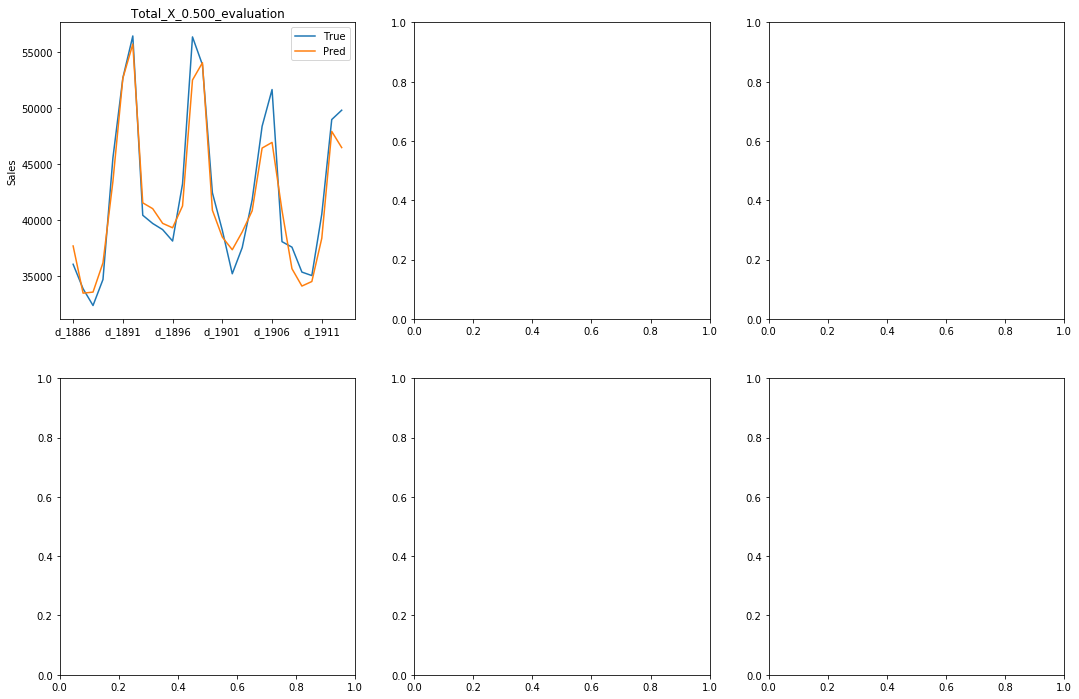

In [12]:
metrics, df = lazy_evaluate_model(model)

In [13]:
model.save(model_dir + "model_batch64_dense64_adamlr1e-4_epochs50_steps100.h5")

## Dense(32)

In [14]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8, num_nodes=32)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 174)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           5600        input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
______________________________________________________________________________________________

In [15]:
logger = Logger(val_batch_creator)

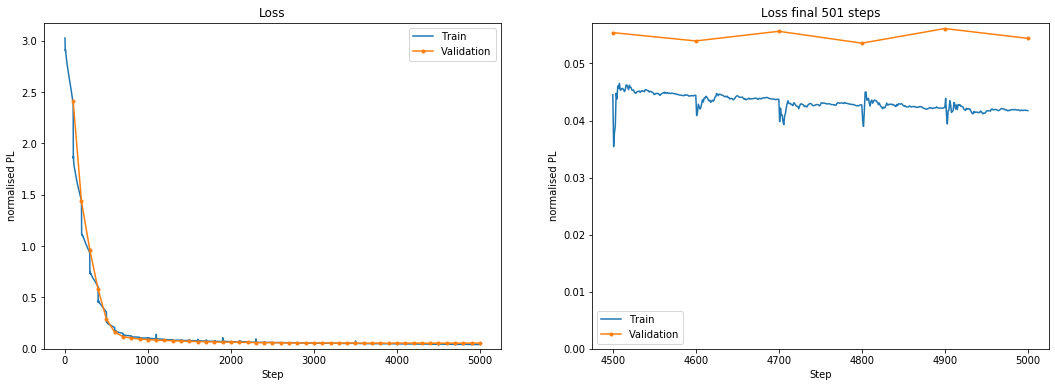

100/100 [==============================] - 11s 113ms/step - loss: 0.0417 - q0_loss: 7.4092e-04 - q1_loss: 0.0022 - q2_loss: 0.0057 - q3_loss: 0.0080 - q4_loss: 0.0087 - q5_loss: 0.0076 - q6_loss: 0.0060 - q7_loss: 0.0022 - q8_loss: 6.4752e-04 - val_loss: 0.0544 - val_q0_loss: 9.3200e-04 - val_q1_loss: 0.0020 - val_q2_loss: 0.0106 - val_q3_loss: 0.0109 - val_q4_loss: 0.0109 - val_q5_loss: 0.0085 - val_q6_loss: 0.0078 - val_q7_loss: 0.0021 - val_q8_loss: 7.4582e-04


In [16]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.0689705814750142, 'WSPL': 0.0689705814750142}


IndexError: single positional indexer is out-of-bounds

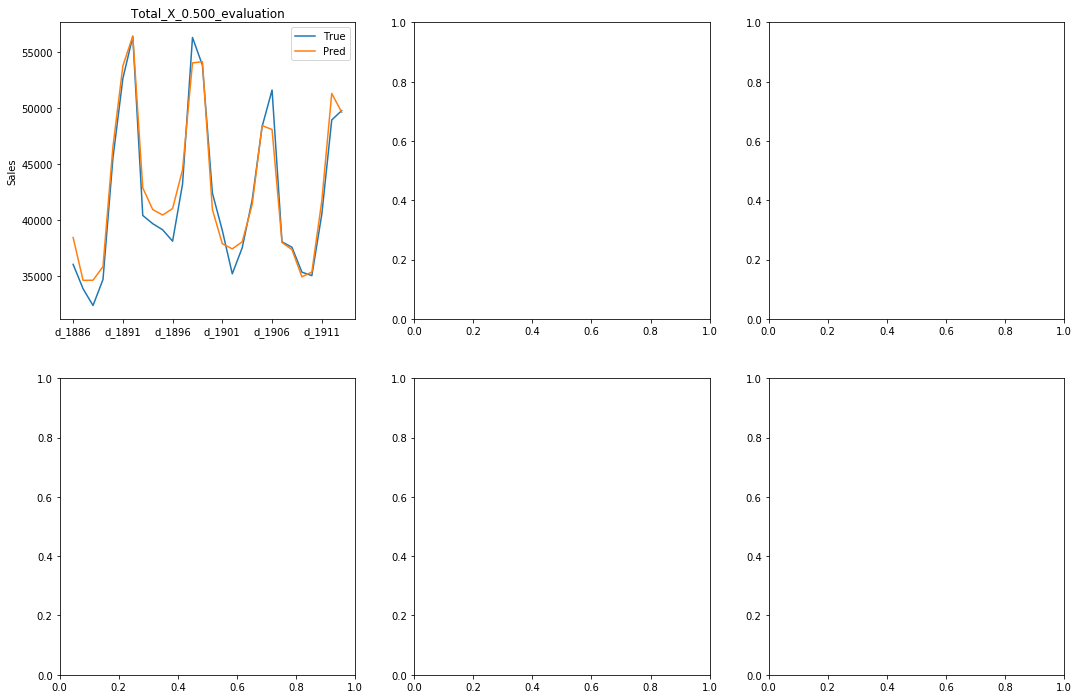

In [17]:
metrics, df = lazy_evaluate_model(model)

In [18]:
model.save(model_dir + "model_batch64_dense32_adamlr1e-4_epochs50_steps100.h5")

## Dense(16)

In [35]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8, num_nodes=16)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 174)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           2800        input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           272         dense_1[0][0]                    
______________________________________________________________________________________________

In [36]:
logger = Logger(val_batch_creator)

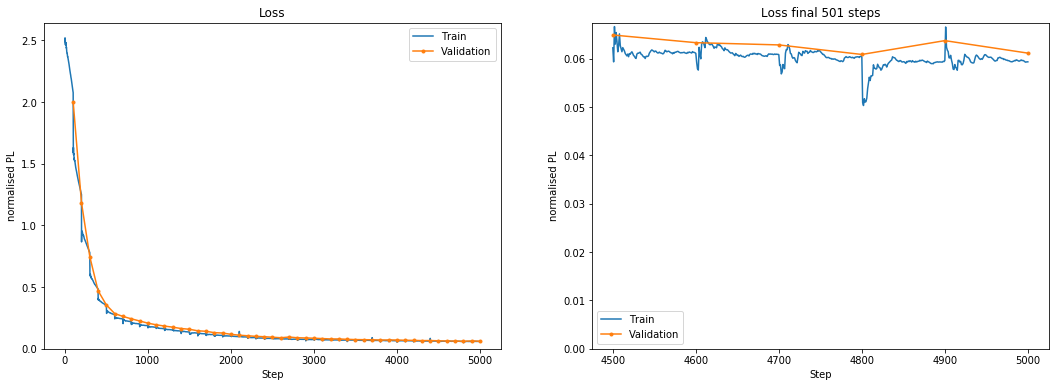

100/100 [==============================] - 4s 35ms/step - loss: 0.0594 - q0_loss: 0.0024 - q1_loss: 0.0027 - q2_loss: 0.0079 - q3_loss: 0.0103 - q4_loss: 0.0125 - q5_loss: 0.0112 - q6_loss: 0.0086 - q7_loss: 0.0028 - q8_loss: 0.0011 - val_loss: 0.0612 - val_q0_loss: 0.0022 - val_q1_loss: 0.0021 - val_q2_loss: 0.0075 - val_q3_loss: 0.0098 - val_q4_loss: 0.0123 - val_q5_loss: 0.0130 - val_q6_loss: 0.0115 - val_q7_loss: 0.0020 - val_q8_loss: 8.5111e-04


In [37]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.07753995777794664, 'WSPL': 0.07753995777794664}


IndexError: single positional indexer is out-of-bounds

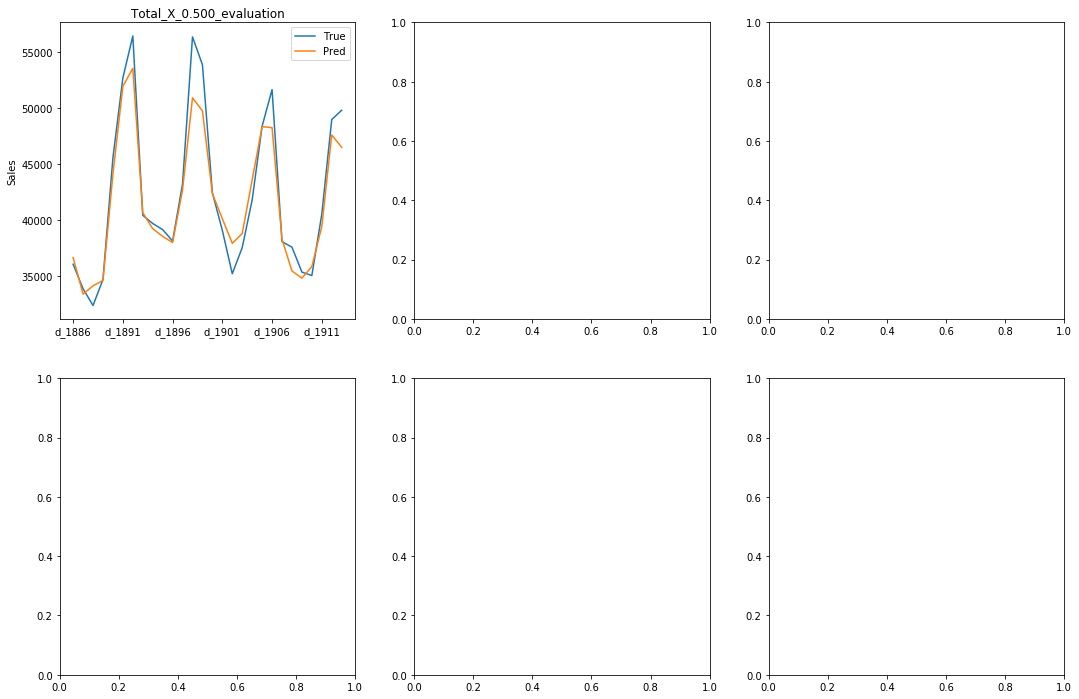

In [38]:
metrics, df = lazy_evaluate_model(model)

In [39]:
model.save(model_dir + "model_batch64_dense16_adamlr1e-4_epochs50_steps100.h5")

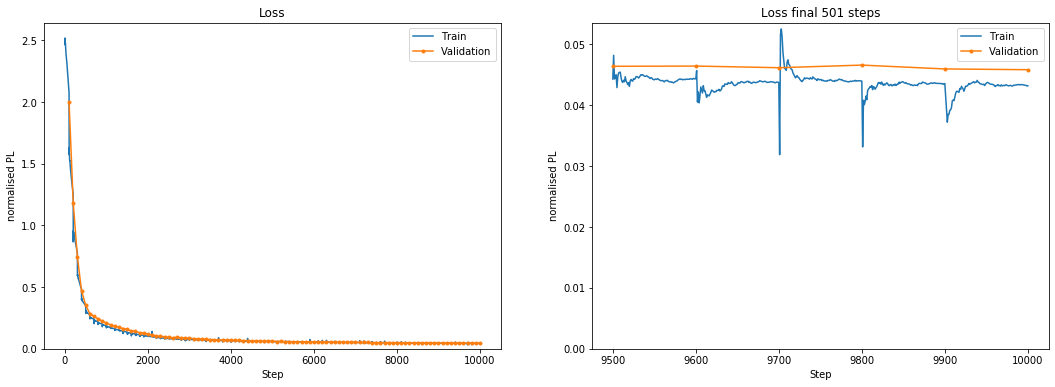

100/100 [==============================] - 4s 40ms/step - loss: 0.0432 - q0_loss: 0.0013 - q1_loss: 0.0016 - q2_loss: 0.0058 - q3_loss: 0.0074 - q4_loss: 0.0093 - q5_loss: 0.0084 - q6_loss: 0.0065 - q7_loss: 0.0020 - q8_loss: 8.0785e-04 - val_loss: 0.0458 - val_q0_loss: 0.0010 - val_q1_loss: 0.0018 - val_q2_loss: 0.0066 - val_q3_loss: 0.0080 - val_q4_loss: 0.0100 - val_q5_loss: 0.0090 - val_q6_loss: 0.0070 - val_q7_loss: 0.0017 - val_q8_loss: 6.5255e-04


In [40]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.05808277931964435, 'WSPL': 0.05808277931964435}


IndexError: single positional indexer is out-of-bounds

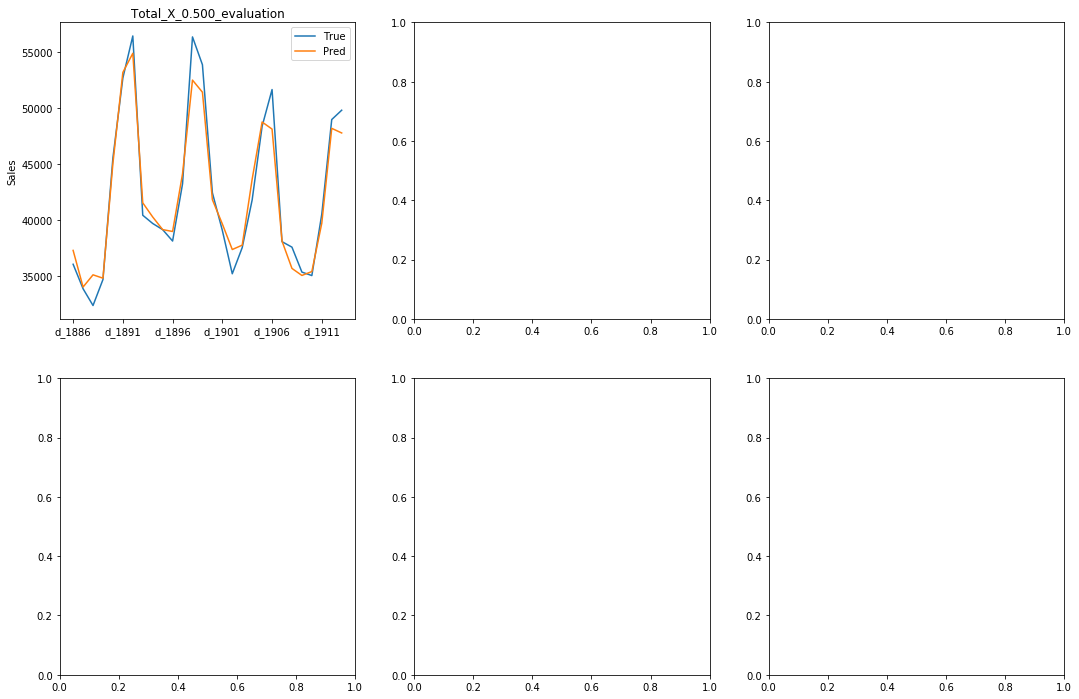

In [41]:
metrics, df = lazy_evaluate_model(model)

In [42]:
model.save(model_dir + "model_batch64_dense16_adamlr1e-4_epochs100_steps100.h5")

### Train dist model

In [20]:
model = get_simple_dist_model(inp_shape=INP_SHAPE)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 174)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11200       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [21]:
logger = Logger(val_batch_creator)

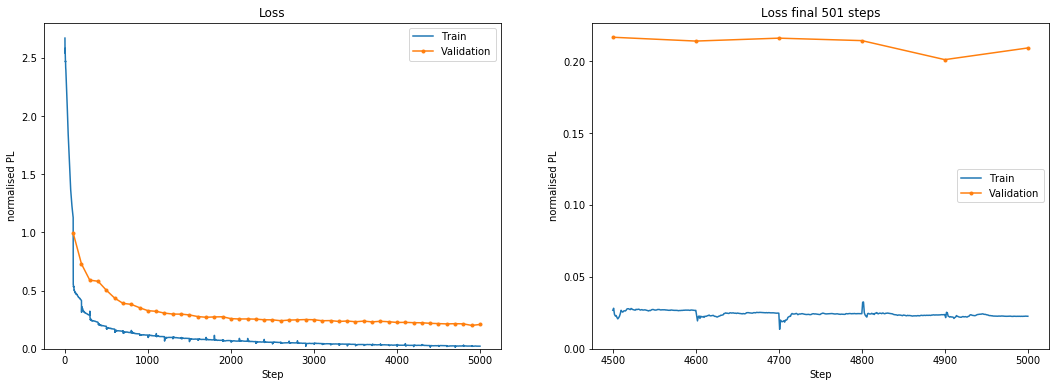

100/100 [==============================] - 13s 131ms/step - loss: 0.0226 - q0_loss: 0.0025 - q1_loss: 0.0025 - q2_loss: 0.0025 - q3_loss: 0.0025 - q4_loss: 0.0025 - q5_loss: 0.0025 - q6_loss: 0.0026 - q7_loss: 0.0026 - q8_loss: 0.0026 - val_loss: 0.2091 - val_q0_loss: 0.0055 - val_q1_loss: 0.0062 - val_q2_loss: 0.0112 - val_q3_loss: 0.0143 - val_q4_loss: 0.0232 - val_q5_loss: 0.0322 - val_q6_loss: 0.0352 - val_q7_loss: 0.0403 - val_q8_loss: 0.0410


In [22]:
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.26515569968946656, 'WSPL': 0.26515569968946656}


IndexError: single positional indexer is out-of-bounds

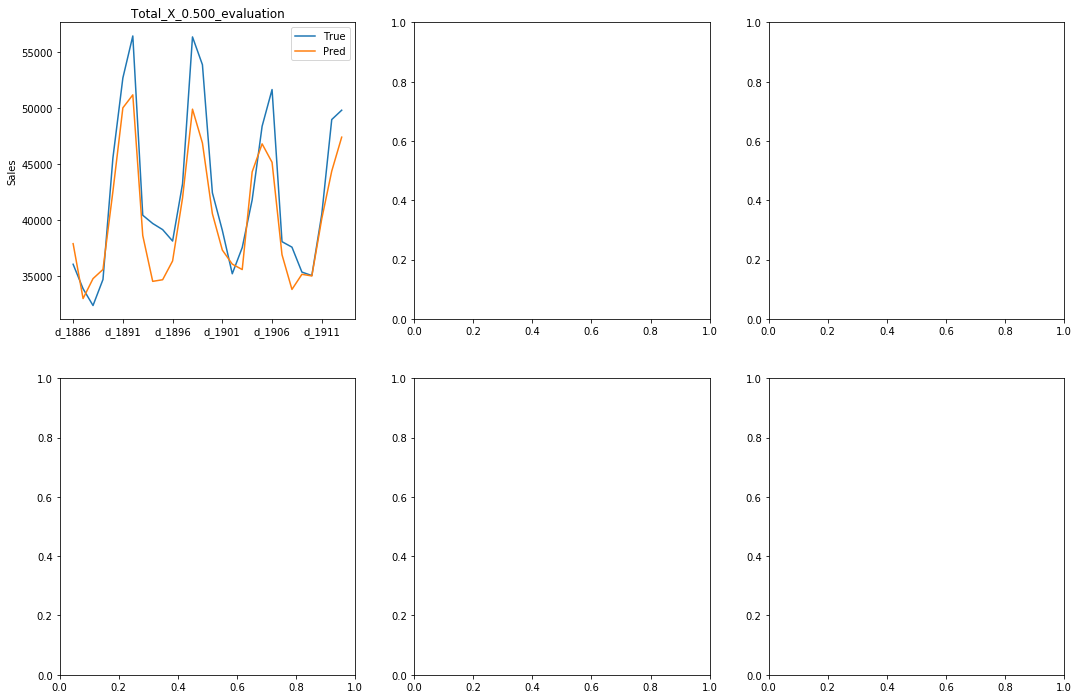

In [23]:
metrics, df = lazy_evaluate_model(model)

In [24]:
model.save(model_dir + "model_batch64_dist64_adamlr1e-4_epochs50_steps100.h5")

### Dist(32)

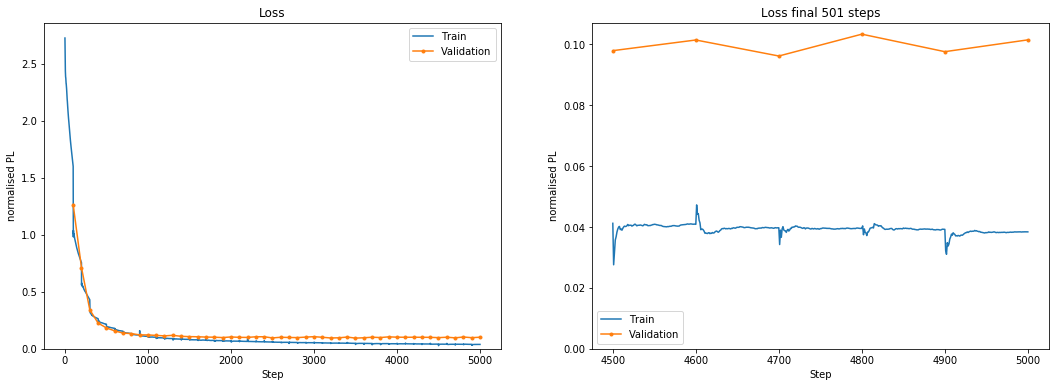

100/100 [==============================] - 11s 112ms/step - loss: 0.0384 - q0_loss: 4.2290e-04 - q1_loss: 0.0014 - q2_loss: 0.0055 - q3_loss: 0.0069 - q4_loss: 0.0091 - q5_loss: 0.0074 - q6_loss: 0.0058 - q7_loss: 0.0015 - q8_loss: 4.0959e-04 - val_loss: 0.1015 - val_q0_loss: 0.0033 - val_q1_loss: 0.0051 - val_q2_loss: 0.0123 - val_q3_loss: 0.0154 - val_q4_loss: 0.0193 - val_q5_loss: 0.0172 - val_q6_loss: 0.0150 - val_q7_loss: 0.0083 - val_q8_loss: 0.0056


In [25]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=32)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.12855241069067, 'WSPL': 0.12855241069067}


IndexError: single positional indexer is out-of-bounds

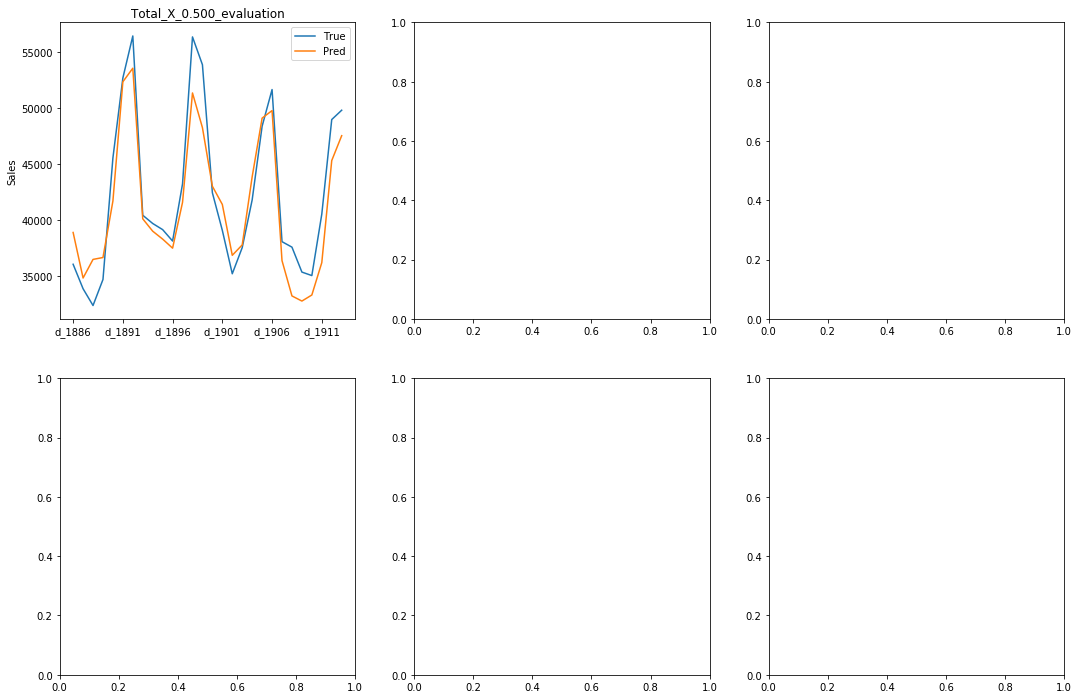

In [27]:
metrics, df = lazy_evaluate_model(model)

In [28]:
model.save(model_dir + "model_batch64_dist32_adamlr1e-4_epochs50_steps100.h5")

### Dist(16)

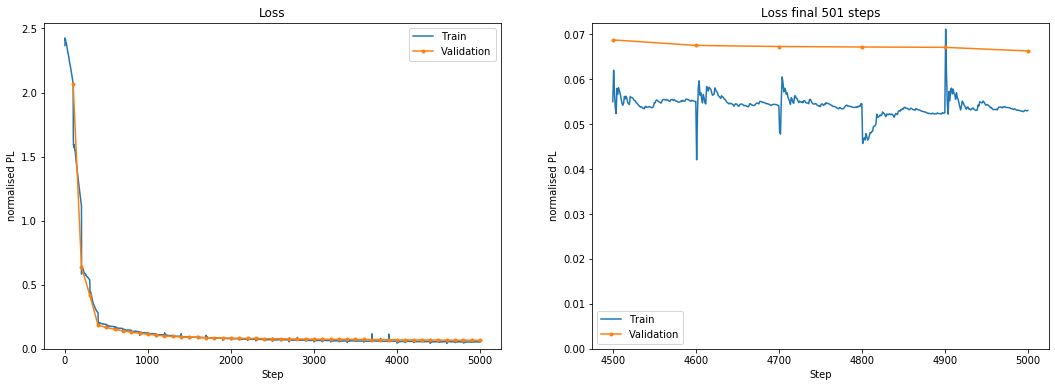

100/100 [==============================] - 11s 110ms/step - loss: 0.0530 - q0_loss: 0.0012 - q1_loss: 0.0027 - q2_loss: 0.0080 - q3_loss: 0.0097 - q4_loss: 0.0119 - q5_loss: 0.0094 - q6_loss: 0.0075 - q7_loss: 0.0020 - q8_loss: 6.0104e-04 - val_loss: 0.0663 - val_q0_loss: 5.7491e-04 - val_q1_loss: 0.0027 - val_q2_loss: 0.0109 - val_q3_loss: 0.0132 - val_q4_loss: 0.0145 - val_q5_loss: 0.0118 - val_q6_loss: 0.0099 - val_q7_loss: 0.0021 - val_q8_loss: 5.6030e-04


In [29]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=16)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.08398369536762224, 'WSPL': 0.08398369536762224}


IndexError: single positional indexer is out-of-bounds

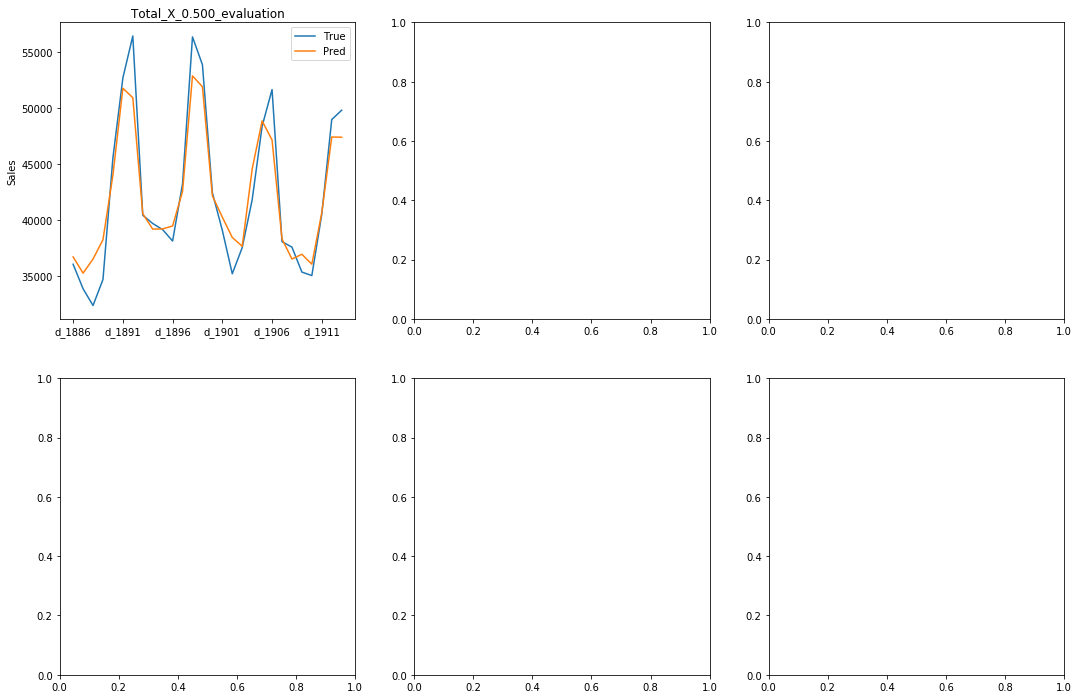

In [30]:
metrics, df = lazy_evaluate_model(model)

In [31]:
model.save(model_dir + "model_batch64_dist16_adamlr1e-4_epochs50_steps100.h5")

# Differ batch sizes with best model (dense 32, 50 epochs)

### Batch 128

In [43]:
def get_generators(batch_size=128):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

In [44]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 174)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11200       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [45]:
logger = Logger(val_batch_creator)

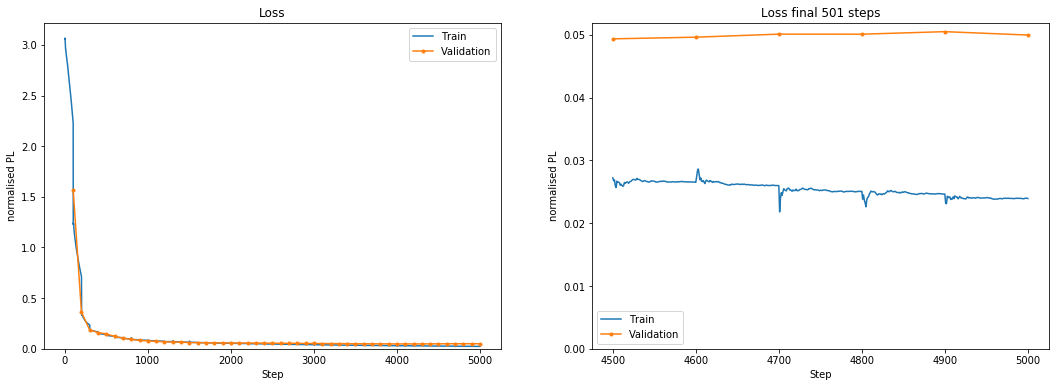

100/100 [==============================] - 5s 49ms/step - loss: 0.0239 - q0_loss: 5.0506e-04 - q1_loss: 0.0017 - q2_loss: 0.0032 - q3_loss: 0.0037 - q4_loss: 0.0053 - q5_loss: 0.0044 - q6_loss: 0.0033 - q7_loss: 0.0013 - q8_loss: 5.8590e-04 - val_loss: 0.0500 - val_q0_loss: 5.4044e-04 - val_q1_loss: 0.0028 - val_q2_loss: 0.0101 - val_q3_loss: 0.0108 - val_q4_loss: 0.0105 - val_q5_loss: 0.0076 - val_q6_loss: 0.0056 - val_q7_loss: 0.0016 - val_q8_loss: 5.2172e-04


In [46]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.0632615997692367, 'WSPL': 0.0632615997692367}


IndexError: single positional indexer is out-of-bounds

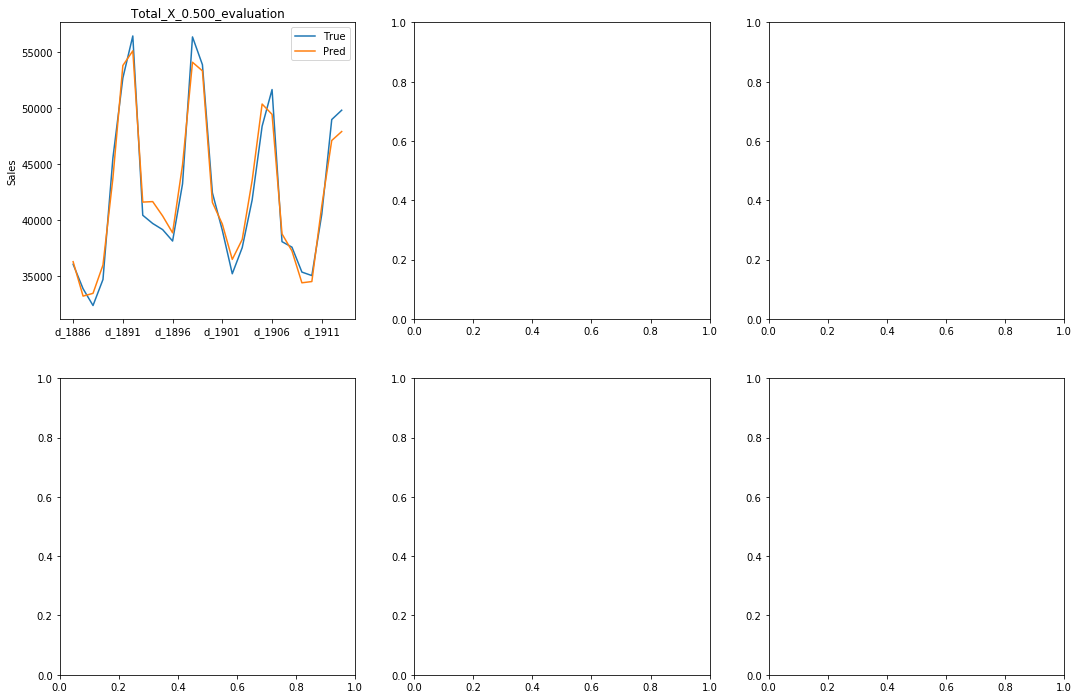

In [47]:
metrics, df = lazy_evaluate_model(model)

In [48]:
model.save(model_dir + "model_batch128_dense32_adamlr1e-4_epochs50_steps100.h5")

### Batch 32

In [49]:
def get_generators(batch_size=32):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

In [50]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 174)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11200       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [51]:
logger = Logger(val_batch_creator)

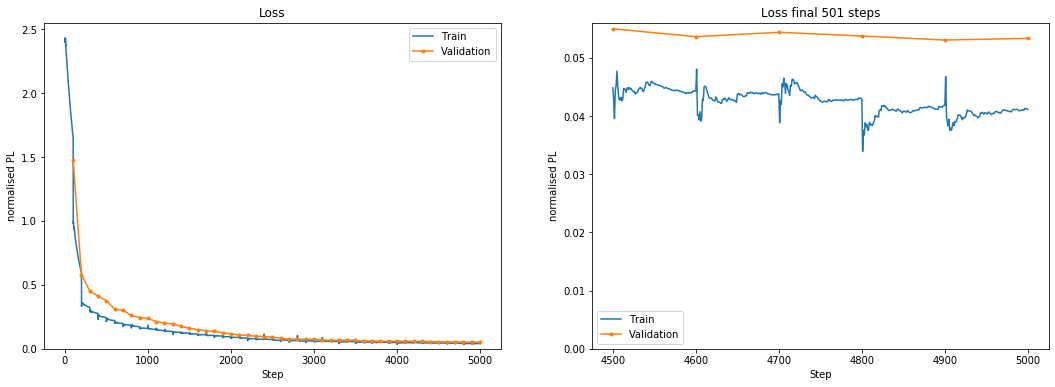

100/100 [==============================] - 5s 49ms/step - loss: 0.0412 - q0_loss: 5.4433e-04 - q1_loss: 0.0034 - q2_loss: 0.0053 - q3_loss: 0.0066 - q4_loss: 0.0086 - q5_loss: 0.0073 - q6_loss: 0.0070 - q7_loss: 0.0018 - q8_loss: 5.8846e-04 - val_loss: 0.0534 - val_q0_loss: 6.8867e-04 - val_q1_loss: 0.0028 - val_q2_loss: 0.0070 - val_q3_loss: 0.0103 - val_q4_loss: 0.0104 - val_q5_loss: 0.0093 - val_q6_loss: 0.0096 - val_q7_loss: 0.0018 - val_q8_loss: 0.0014


In [52]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.06763215546265448, 'WSPL': 0.06763215546265448}


IndexError: single positional indexer is out-of-bounds

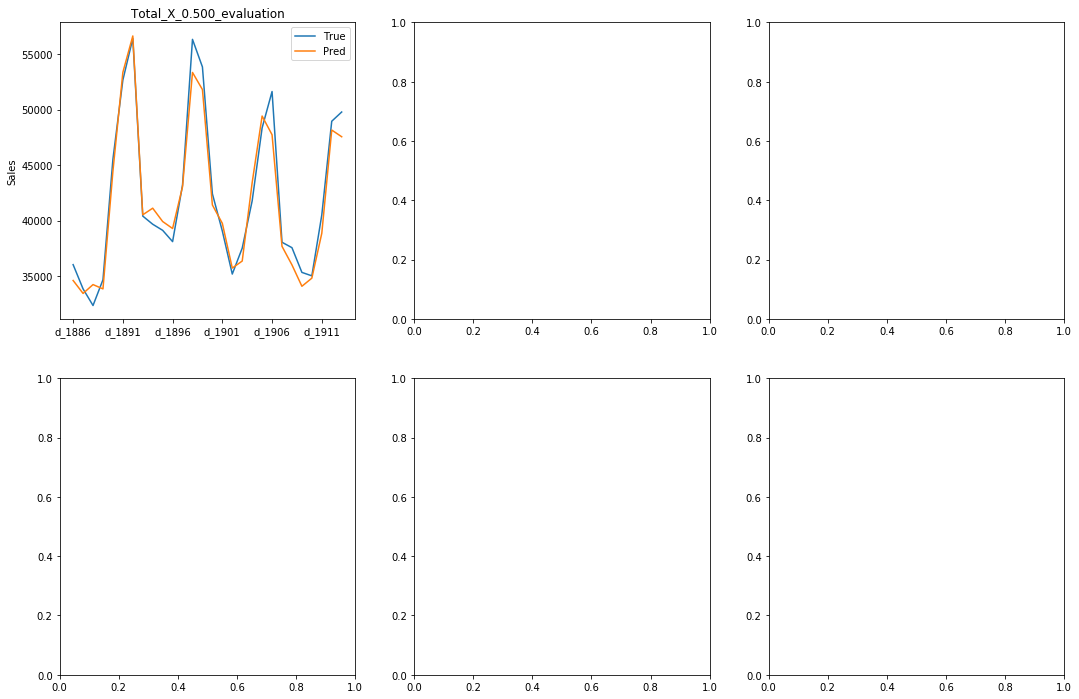

In [53]:
metrics, df = lazy_evaluate_model(model)

In [54]:
model.save(model_dir + "model_batch32_dense32_adamlr1e-4_epochs50_steps100.h5")

### Now let's increase the learning rate a bit (Dense 32, batchsize 128, epochs 50)

### LR 1e-3 (Adam)

In [55]:
def get_generators(batch_size=128):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

In [56]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 174)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11200       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [51]:
logger = Logger(val_batch_creator)

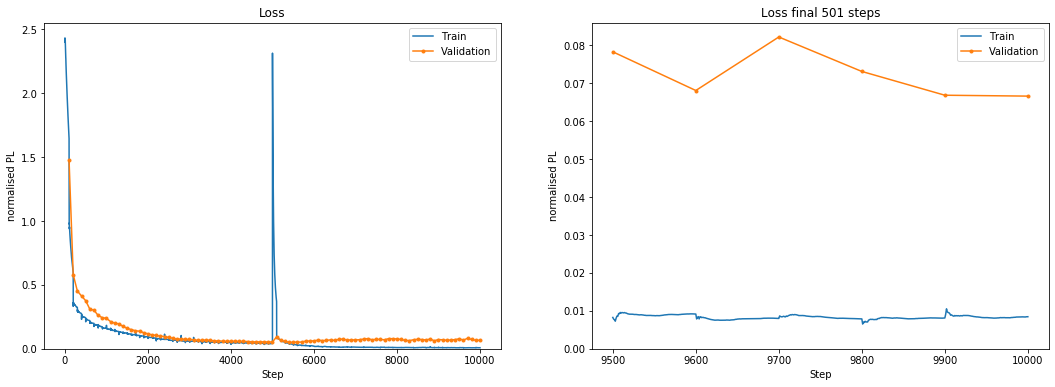

100/100 [==============================] - 4s 41ms/step - loss: 0.0085 - q0_loss: 1.0324e-04 - q1_loss: 4.0256e-04 - q2_loss: 0.0012 - q3_loss: 0.0016 - q4_loss: 0.0018 - q5_loss: 0.0015 - q6_loss: 0.0012 - q7_loss: 4.0206e-04 - q8_loss: 1.1903e-04 - val_loss: 0.0666 - val_q0_loss: 0.0017 - val_q1_loss: 0.0066 - val_q2_loss: 0.0083 - val_q3_loss: 0.0090 - val_q4_loss: 0.0108 - val_q5_loss: 0.0109 - val_q6_loss: 0.0082 - val_q7_loss: 0.0039 - val_q8_loss: 0.0072


In [57]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.08423803723476891, 'WSPL': 0.08423803723476891}


IndexError: single positional indexer is out-of-bounds

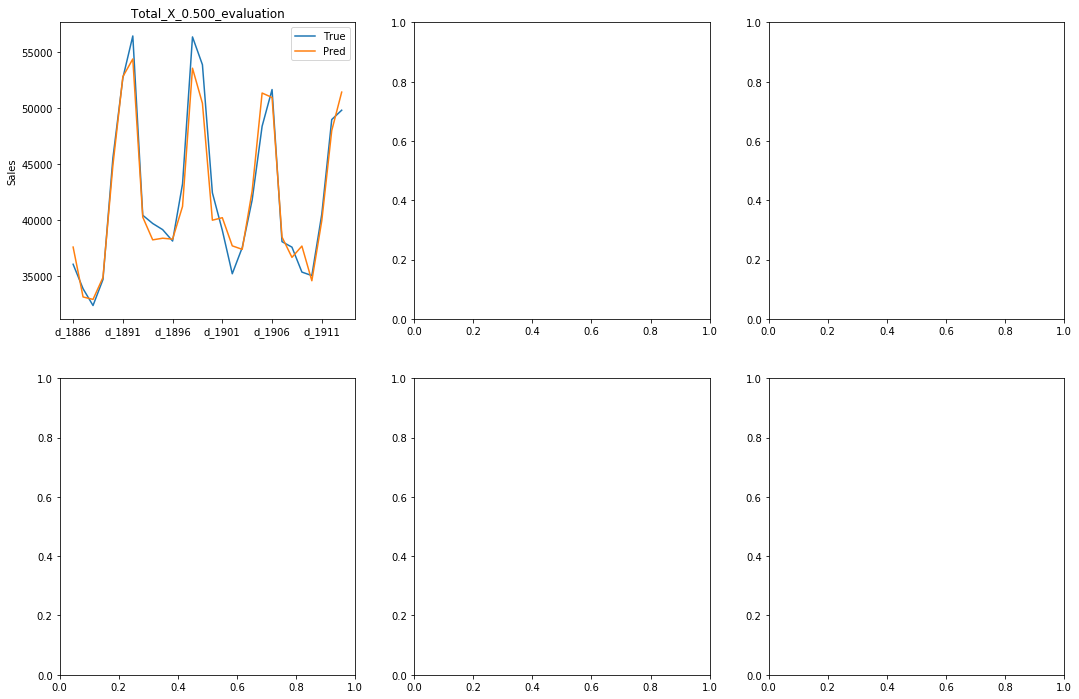

In [58]:
metrics, df = lazy_evaluate_model(model)

In [59]:
model.save(model_dir + "model_batch128_dense32_adamlr1e-3_epochs50_steps100.h5")

### LR 1e-5(Adam)

In [71]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8)
model.compile(optimizer=Adam(learning_rate=1e-5), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 174)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11200       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [72]:
logger = Logger(val_batch_creator)

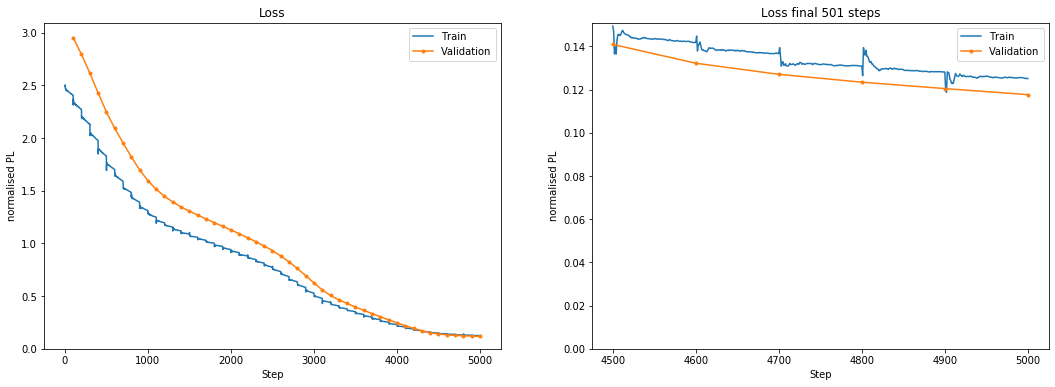

100/100 [==============================] - 5s 47ms/step - loss: 0.1252 - q0_loss: 0.0017 - q1_loss: 0.0169 - q2_loss: 0.0159 - q3_loss: 0.0202 - q4_loss: 0.0279 - q5_loss: 0.0190 - q6_loss: 0.0163 - q7_loss: 0.0056 - q8_loss: 0.0017 - val_loss: 0.1177 - val_q0_loss: 8.5541e-04 - val_q1_loss: 0.0204 - val_q2_loss: 0.0109 - val_q3_loss: 0.0198 - val_q4_loss: 0.0249 - val_q5_loss: 0.0141 - val_q6_loss: 0.0175 - val_q7_loss: 0.0026 - val_q8_loss: 0.0066


In [73]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.14915385230973838, 'WSPL': 0.14915385230973838}


IndexError: single positional indexer is out-of-bounds

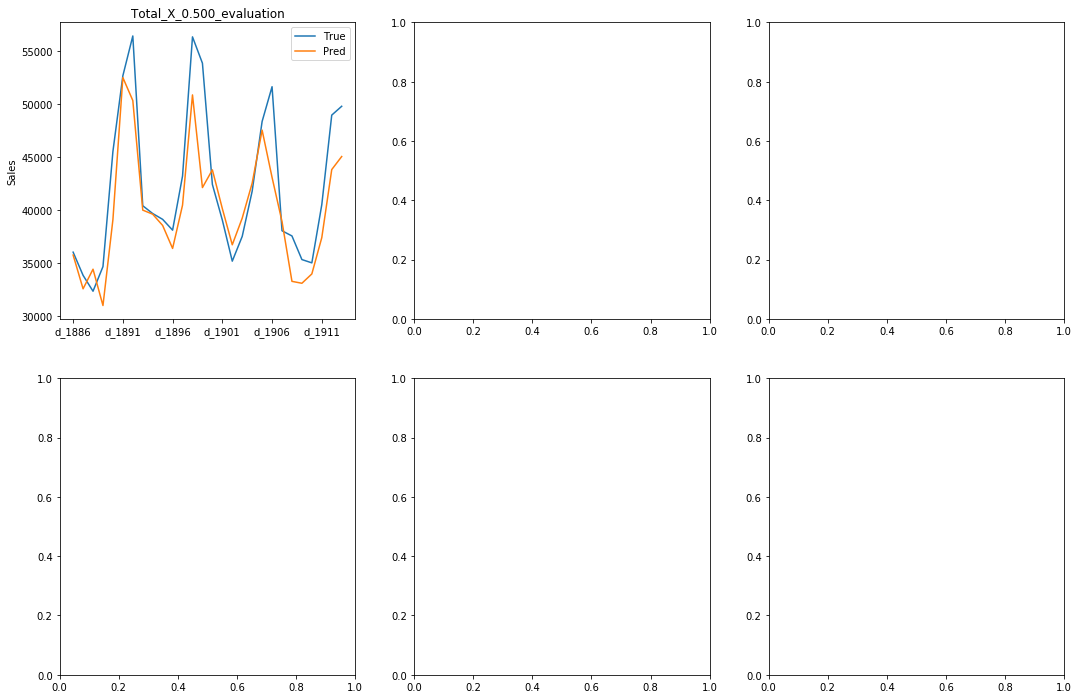

In [74]:
metrics, df = lazy_evaluate_model(model)

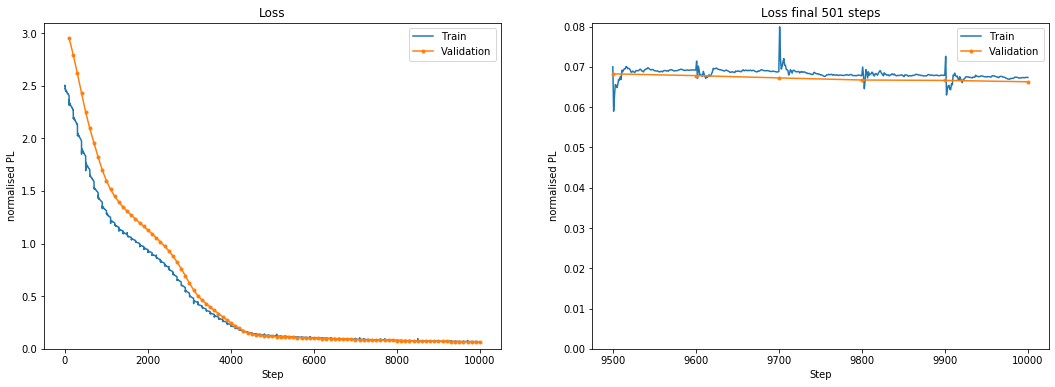

100/100 [==============================] - 4s 41ms/step - loss: 0.0673 - q0_loss: 0.0010 - q1_loss: 0.0044 - q2_loss: 0.0093 - q3_loss: 0.0117 - q4_loss: 0.0148 - q5_loss: 0.0111 - q6_loss: 0.0099 - q7_loss: 0.0039 - q8_loss: 0.0012 - val_loss: 0.0663 - val_q0_loss: 7.2868e-04 - val_q1_loss: 0.0045 - val_q2_loss: 0.0089 - val_q3_loss: 0.0111 - val_q4_loss: 0.0122 - val_q5_loss: 0.0106 - val_q6_loss: 0.0148 - val_q7_loss: 0.0024 - val_q8_loss: 0.0010


In [75]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.08405799676145304, 'WSPL': 0.08405799676145304}


IndexError: single positional indexer is out-of-bounds

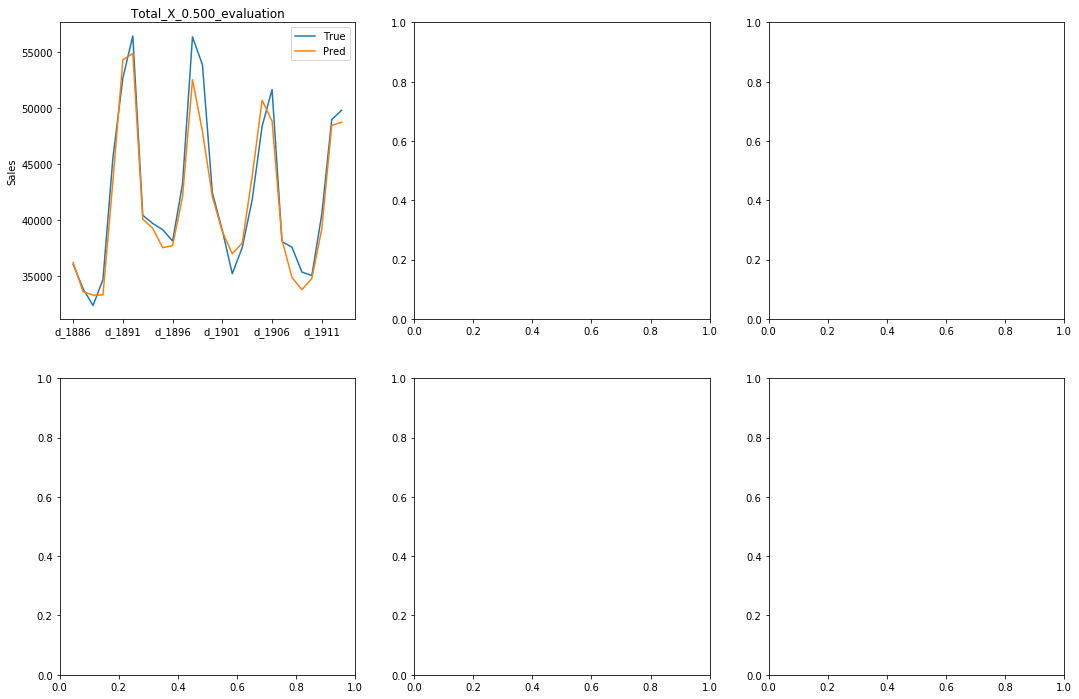

In [76]:
metrics, df = lazy_evaluate_model(model)

In [77]:
model.save(model_dir + "model_batch128_dense32_adamlr1e-5_epochs100_steps100.h5")